Network Built: 154 Nodes, 4046 Edges

Top 10 Most Central Actors (Hubs):
                                                Actor       Category  \
9                    Canada Foundation for Innovation     Government   
21                              Global Affairs Canada     Government   
4                 Business Development Bank of Canada     Government   
83  Innovation, Science and Economic Development C...     Government   
68                                             D-Wave       Industry   
67                           Creative Destruction Lab  Civil Society   
70                                               DRDC     Government   
71            Defence Research and Development Canada     Government   
72                     Department of National Defence     Government   
69                                                DND     Government   

    Degree_Centrality  Betweenness_Centrality  
9            0.764706                0.235681  
21           0.764706                0

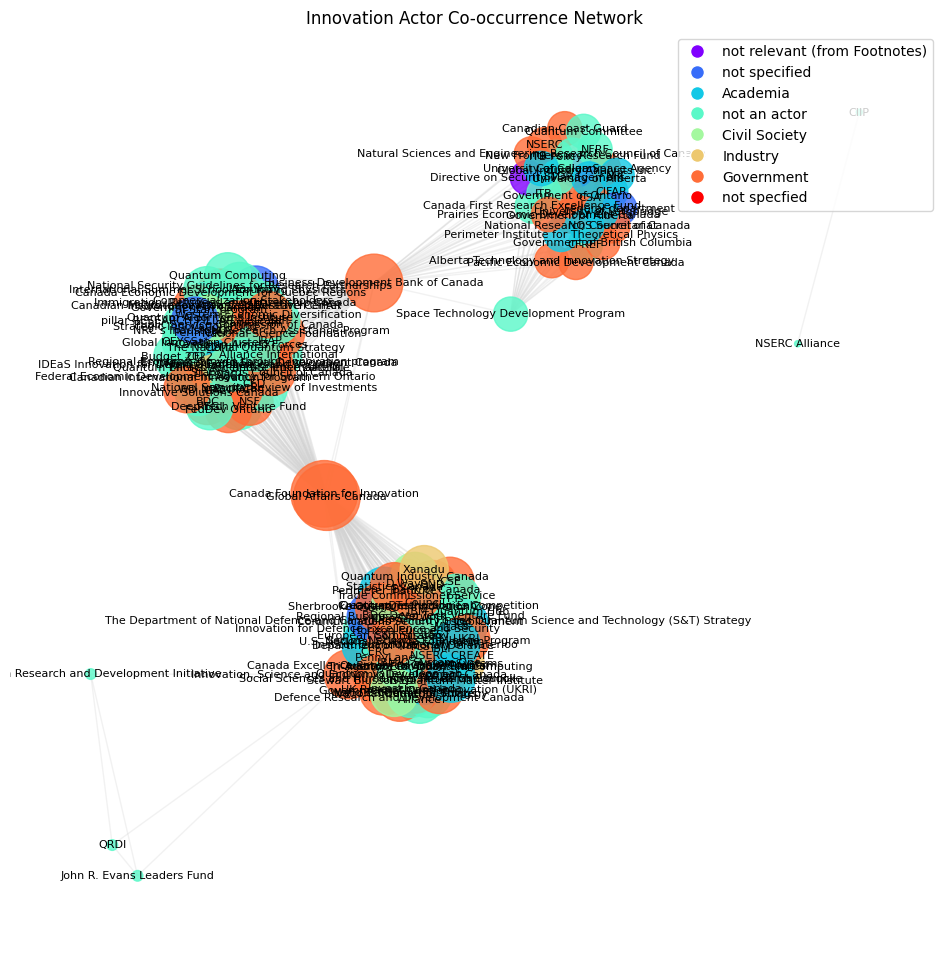

In [1]:
# Cell 7: Network Visualization and Analysis
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import pandas as pd

# Load data
df = pd.read_csv("entities_ready_for_network.csv")

# Initialize Graph
G = nx.Graph()

# --- A. Build Edges (Co-occurrence in Block) ---
# Group by Document and Block (Paragraph level co-occurrence)
grouped = df.groupby(['Doc_ID', 'Block_ID'])['Label'].apply(list)

edge_list = []
for actors in grouped:
    # We need at least 2 actors to form a link
    if len(actors) > 1:
        # Sort to ensure (A,B) is same as (B,A)
        for u, v in combinations(sorted(actors), 2):
            edge_list.append((u, v))

# Add edges with weights (frequency of co-occurrence)
for u, v in edge_list:
    if G.has_edge(u, v):
        G[u][v]['weight'] += 1
    else:
        G.add_edge(u, v, weight=1)

# Add Node Attributes (Category)
# Create a mapping of Label -> Category
cat_map = df.set_index('Label')['qh_category'].to_dict()
nx.set_node_attributes(G, cat_map, name="category")

print(f"Network Built: {G.number_of_nodes()} Nodes, {G.number_of_edges()} Edges")

# --- B. Calculate Centrality (Emphasis) ---
degree_cent = nx.degree_centrality(G)
betweenness_cent = nx.betweenness_centrality(G)

# Create a DataFrame for Analysis
ranking = pd.DataFrame({
    'Actor': list(G.nodes()),
    'Category': [G.nodes[n]['category'] for n in G.nodes()],
    'Degree_Centrality': [degree_cent[n] for n in G.nodes()],
    'Betweenness_Centrality': [betweenness_cent[n] for n in G.nodes()]
}).sort_values(by='Degree_Centrality', ascending=False)

print("\nTop 10 Most Central Actors (Hubs):")
print(ranking.head(10))
ranking.to_csv("rq2_network_stats.csv", index=False)

# --- C. Visualization (Static) ---
plt.figure(figsize=(12, 12))

# Layout algorithm (Spring usually works best for social networks)
pos = nx.spring_layout(G, k=0.15, iterations=20, seed=42)

# Color mapping for categories
categories = list(set(cat_map.values()))
colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))
color_map = {cat: col for cat, col in zip(categories, colors)}
node_colors = [color_map.get(G.nodes[n]['category'], 'grey') for n in G.nodes()]

# Draw
nx.draw_networkx_nodes(G, pos, node_size=[v * 3000 for v in degree_cent.values()], node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='lightgrey')
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

# Legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=cat,
                          markerfacecolor=col, markersize=10) for cat, col in color_map.items()]
plt.legend(handles=legend_elements, loc='upper right')

plt.title("Innovation Actor Co-occurrence Network")
plt.axis('off')
plt.show()

Loading data...
Building entity lookup map...
Scanning 528 paragraphs. This may take a moment...


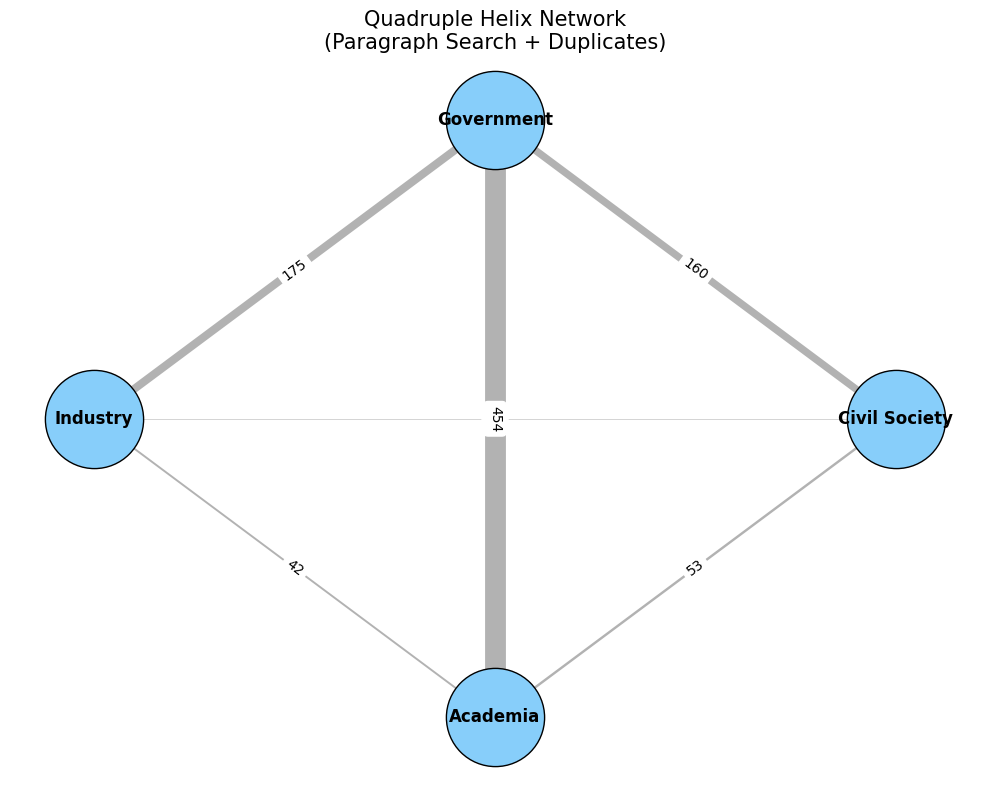

✅ Graph generated with duplicate weighting!


In [3]:
import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import re

# --- 1. CONFIGURATION ---
TARGETS = ["Civil Society", "Government", "Industry", "Academia"]

# Files (Ensure these match your actual filenames)
text_csv = "output.csv"       # The file with 'Paragraph_ID' and 'text'
entities_csv = "2entities_to_edit.csv"    # The file with 'qh_category' (manual or auto)

# --- 2. LOAD & PREPARE DATA ---
print("Loading data...")
df_text = pd.read_csv(text_csv).fillna("")
df_ent = pd.read_csv(entities_csv).fillna("")

# Filter for the 4 Helix Categories
df_ent['qh_category'] = df_ent['qh_category'].astype(str).str.strip()
df_ent = df_ent[df_ent['qh_category'].isin(TARGETS)]

# Optimize: Create a dictionary mapping Doc_ID -> List of (Entity Name, Category)
# This restricts our search scope to only entities that actually belong to the document.
print("Building entity lookup map...")
doc_entity_map = {}

for doc_id, group in df_ent.groupby('Doc_ID'):
    # Store unique entities for this doc
    # We sort by length (descending) so if we wanted to prevent partial matches we could,
    # but here we just store them.
    entities = list(zip(group['entity_name'].astype(str), group['qh_category']))
    doc_entity_map[doc_id] = entities

# --- 3. BUILD NETWORK ---
G = nx.Graph()
G.add_nodes_from(TARGETS)

print(f"Scanning {len(df_text)} paragraphs. This may take a moment...")

for _, row in df_text.iterrows():
    doc_id = row['Doc_ID']
    text = str(row['text'])
    
    # Skip empty text
    if not text.strip(): continue

    # Retrieve potential entities for this document
    potential_entities = doc_entity_map.get(doc_id, [])
    
    if not potential_entities:
        continue

    # Find ALL occurrences of entities in this paragraph (including duplicates)
    found_categories = []
    
    for name, category in potential_entities:
        # Regex search: Case-insensitive
        # re.escape handles special characters in names (like "D-Wave")
        matches = re.findall(re.escape(name), text, re.IGNORECASE)
        
        # If "Government" appears 3 times, we add 'Government' 3 times to the list
        if matches:
            found_categories.extend([category] * len(matches))

    # If fewer than 2 entities found, no interaction possible
    if len(found_categories) < 2:
        continue

    # Generate Interactions (Clique)
    # We create links between EVERY combination found.
    # If found_categories = [Gov, Gov, Ind], we get pairs: (Gov, Gov), (Gov, Ind), (Gov, Ind)
    # We filter out self-loops (c1 != c2) unless you specifically want them.
    for c1, c2 in itertools.combinations(sorted(found_categories), 2):
        if c1 != c2:  # Only count cross-category interactions
            if G.has_edge(c1, c2):
                G[c1][c2]['weight'] += 1
            else:
                G.add_edge(c1, c2, weight=1)

# --- 4. VISUALIZE ---
plt.figure(figsize=(10, 8))
pos = nx.circular_layout(G)

edges = G.edges(data=True)
weights = [data['weight'] for u, v, data in edges]
max_weight = max(weights) if weights else 1

# Draw
nx.draw_networkx_nodes(G, pos, node_size=5000, node_color='#87CEFA', edgecolors='black')
nx.draw_networkx_edges(G, pos, width=[(w / max_weight) * 15 for w in weights], alpha=0.6, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Edge Labels
edge_labels = {(u, v): d['weight'] for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Quadruple Helix Network\n(Paragraph Search + Duplicates)", fontsize=15)
plt.axis('off')
plt.tight_layout()

plt.savefig("qh_network_search_duplicates.png")
plt.show()

print("✅ Graph generated with duplicate weighting!")

Loading data...
Scanning 528 paragraphs for interactions...

Generating Interaction Matrix...
Interaction Matrix:
               Civil Society  Government  Industry  Academia
Civil Society              0         182        12        60
Government               182           0       175       454
Industry                  12         175         0        42
Academia                  60         454        42         0


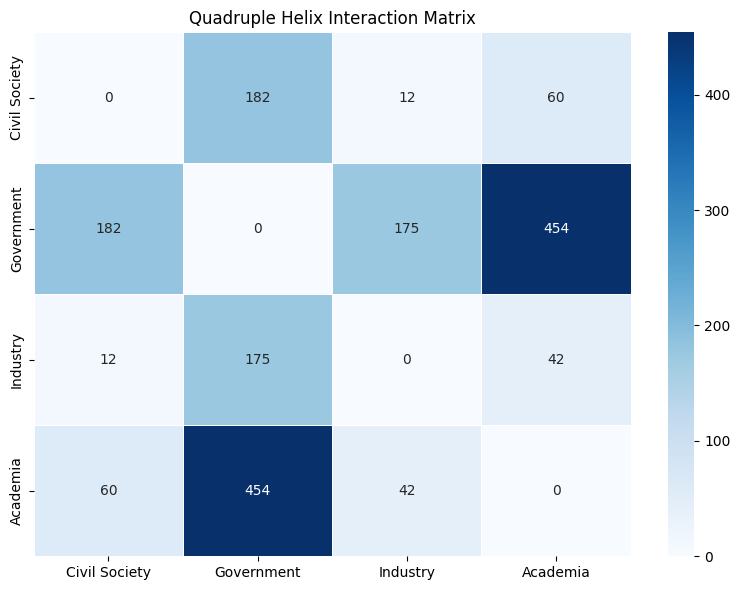

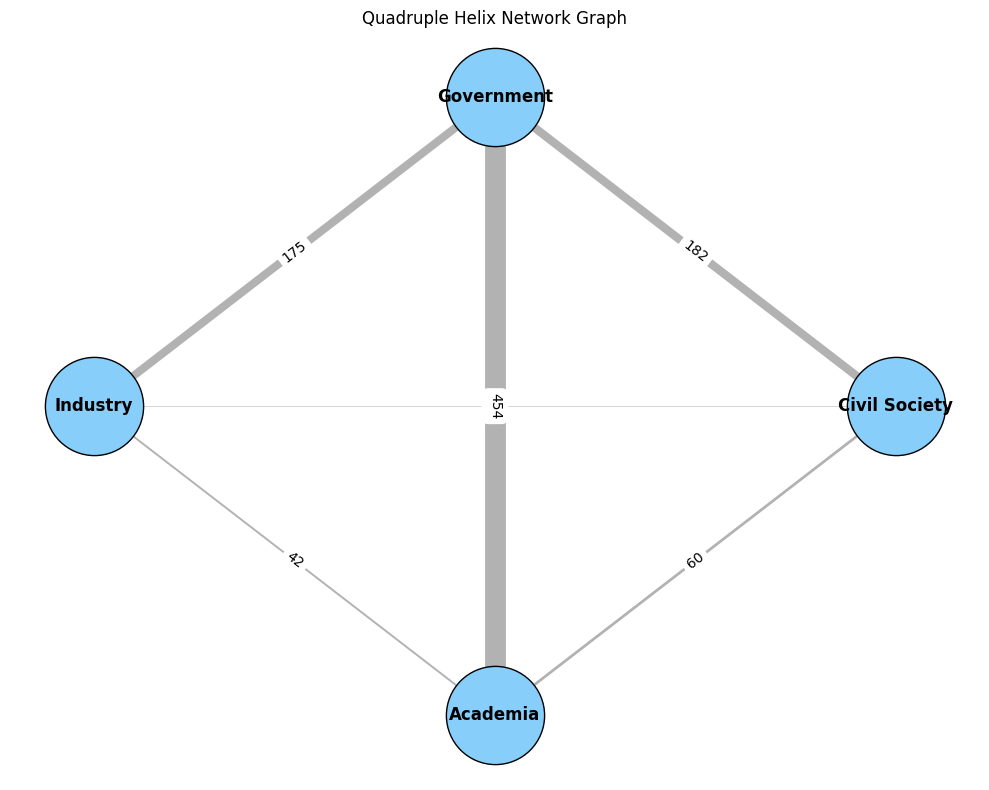

✅ Outputs saved:
 1. qh_interaction_matrix.csv
 2. qh_matrix_heatmap.png
 3. qh_network_graph.png


In [4]:
import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import re

# --- 1. CONFIGURATION ---
TARGETS = ["Civil Society", "Government", "Industry", "Academia"]
text_csv = "paragraphs_master.csv"       
entities_csv = "2entities_filled.csv"    

# --- 2. LOAD & PREPARE DATA ---
print("Loading data...")
df_text = pd.read_csv(text_csv).fillna("")
df_ent = pd.read_csv(entities_csv).fillna("")

# Normalize
df_ent['qh_category'] = df_ent['qh_category'].astype(str).str.strip()
df_ent = df_ent[df_ent['qh_category'].isin(TARGETS)]

# Build Lookup Map (Doc_ID -> Entities)
doc_entity_map = {}
for doc_id, group in df_ent.groupby('Doc_ID'):
    # Store (Name, Category) pairs
    entities = list(zip(group['entity_name'].astype(str), group['qh_category']))
    doc_entity_map[doc_id] = entities

# --- 3. BUILD NETWORK ---
G = nx.Graph()
G.add_nodes_from(TARGETS)

print(f"Scanning {len(df_text)} paragraphs for interactions...")

for _, row in df_text.iterrows():
    doc_id = row['Doc_ID']
    text = str(row['text'])
    
    if not text.strip(): continue

    potential_entities = doc_entity_map.get(doc_id, [])
    if not potential_entities: continue

    # Find ALL occurrences (allowing duplicates)
    found_categories = []
    for name, category in potential_entities:
        # Regex search: Case-insensitive
        matches = re.findall(re.escape(name), text, re.IGNORECASE)
        if matches:
            found_categories.extend([category] * len(matches))

    # Need at least 2 entities to interact
    if len(found_categories) < 2: continue

    # Generate Edges
    for c1, c2 in itertools.combinations(sorted(found_categories), 2):
        if c1 != c2:  # Exclude self-loops (e.g. Gov-Gov)
            if G.has_edge(c1, c2):
                G[c1][c2]['weight'] += 1
            else:
                G.add_edge(c1, c2, weight=1)

# --- 4. GENERATE & SAVE MATRIX ---
print("\nGenerating Interaction Matrix...")

# Convert Graph to Pandas DataFrame (Adjacency Matrix)
# nodelist ensures the order is fixed [Civil Society, Gov, Ind, Acad]
matrix_df = nx.to_pandas_adjacency(G, nodelist=TARGETS, weight='weight', dtype=int)

# Save to CSV
output_matrix_file = "qh_interaction_matrix.csv"
matrix_df.to_csv(output_matrix_file)

print("Interaction Matrix:")
print(matrix_df)

# --- 5. VISUALIZATION ---

# Plot 1: Heatmap of the Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_df, annot=True, fmt='d', cmap="Blues", linewidths=.5)
plt.title("Quadruple Helix Interaction Matrix")
plt.tight_layout()
plt.savefig("qh_matrix_heatmap.png")
plt.show()

# Plot 2: Network Graph (Weighted)
plt.figure(figsize=(10, 8))
pos = nx.circular_layout(G)
edges = G.edges(data=True)
weights = [data['weight'] for u, v, data in edges]
max_weight = max(weights) if weights else 1

# Nodes
nx.draw_networkx_nodes(G, pos, node_size=5000, node_color='#87CEFA', edgecolors='black')
# Edges (Thickness = weight)
nx.draw_networkx_edges(G, pos, width=[(w / max_weight) * 15 for w in weights], alpha=0.6, edge_color='gray')
# Labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
edge_labels = {(u, v): d['weight'] for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Quadruple Helix Network Graph")
plt.axis('off')
plt.tight_layout()
plt.savefig("qh_network_graph.png")
plt.show()

print(f"✅ Outputs saved:\n 1. {output_matrix_file}\n 2. qh_matrix_heatmap.png\n 3. qh_network_graph.png")